In [63]:
import pandas as pd
import numpy as np
from datetime import *
from plotnine import *
import statsmodels.api as sm

In [16]:
df = pd.concat([pd.read_csv("data/lichess_swiss_rating_histories_1.csv",parse_dates=['date']),
                pd.read_csv("data/lichess_swiss_rating_histories_2.csv",parse_dates=['date'])])
print(df.shape)
df.head()

(8623368, 4)


,user_id,time_control,date,rating
0,0,Blitz,2019-01-04,2244
1,0,Blitz,2019-01-05,2256
2,0,Blitz,2019-01-06,2231
3,0,Blitz,2019-01-08,2307
4,0,Blitz,2019-01-29,2288


In [5]:
df['user_id'].nunique()

17171

In [6]:
df['date'].max()

'2021-08-03'

In [11]:
# The latest date we have data on
max_outcome_date = df['date'].max()
# The latest date that can be used for training to ensure we'll always have 2 years in advance of outcomes data
max_training_date = max_outcome_date - timedelta(days=365*2)
max_outcome_date,max_training_date

(Timestamp('2021-08-03 00:00:00'), Timestamp('2019-08-04 00:00:00'))

In [13]:
# The earliest date we have data on
minn_training_date = df['date'].min()
minn_training_date

Timestamp('2019-01-01 00:00:00')

In [53]:
# The latest ratings that can be used for training
df_training = df.query('date<=@max_training_date')
df_outcomes = df.query('date>@max_training_date')
latest_training_ratings = df_training.sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
latest_training_ratings.sample(5)

,user_id,time_control,date,rating
637431,11342,Bullet,2019-08-02,2113
2948792,15641,Bullet,2019-08-04,1273
1142598,2667,Rapid,2019-08-03,1518
1083190,2533,Classical,2019-07-23,1282
2248754,14434,Blitz,2019-08-04,1840


# Feature Engineering

In [29]:
# Ratings from X days before the max training date
max_training_date_minus_30 = max_training_date-timedelta(days=30)
max_training_date_minus_90 = max_training_date-timedelta(days=90)
max_training_date_minus_180 = max_training_date-timedelta(days=180)
hist_ratings_30 = df.query('date<=@max_training_date_minus_30').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_90 = df.query('date<=@max_training_date_minus_90').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180 = df.query('date<=@max_training_date_minus_180').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180.head()

,user_id,time_control,date,rating
7033,10091,Blitz,2019-02-05,1106
1488095,13023,Rapid,2019-02-05,1339
1475936,12996,Bullet,2019-02-05,1722
1476181,12996,Rapid,2019-02-05,1812
1476463,12997,Bullet,2019-02-05,1454


In [30]:
# Peak ratings
hist_ratings_peak = df_training.sort_values("rating",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_peak.head()

,user_id,time_control,date,rating
3141002,6935,Bullet,2019-03-26,2872
4478689,9624,Bullet,2019-07-21,2852
2810666,6252,Bullet,2019-06-26,2847
4478286,9624,Blitz,2019-08-04,2833
3039334,6727,Bullet,2019-05-05,2832


In [194]:
# Add features to base table
df_base = latest_training_ratings.merge(hist_ratings_30[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_latest','_30']).merge(
            hist_ratings_90[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control']).merge(
            hist_ratings_180[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_90','_180']).merge(
            hist_ratings_peak[['user_id','time_control','rating']].rename(columns={'rating':'rating_peak'}),
                how='left',on=['user_id','time_control'])
df_base['rating_30_diff'] = df_base['rating_latest']-df_base['rating_30']
df_base['rating_90_diff'] = df_base['rating_latest']-df_base['rating_90']
df_base['rating_180_diff'] = df_base['rating_latest']-df_base['rating_180']
df_base['rating_peak_diff'] = df_base['rating_latest']-df_base['rating_peak']
df_base['time_control_copy'] = df_base['time_control']
df_base['rating_latest_rounded'] = df_base['rating_latest'].round(-2)
df_base = pd.get_dummies(df_base,columns=['time_control_copy'],prefix_sep="")
df_base.columns = [x.replace("time_control_copy","").lower() for x in df_base.columns]
print(df_base.shape)
df_base.sample(10)

(41530, 17)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,rating_180_diff,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid
32933,2002,Bullet,2019-05-04,961,961.0,961.0,NaN,961,0.0,0.0,NaN,0,1000,0,1,0,0
3778,12981,Blitz,2019-08-04,1875,1903.0,1843.0,1787.0,2005,-28.0,32.0,88.0,-130,1900,1,0,0,0
26028,1236,Classical,2019-06-25,1510,1510.0,NaN,NaN,1510,0.0,NaN,NaN,0,1500,0,0,1,0
32616,3663,Bullet,2019-05-07,1419,1419.0,1407.0,1441.0,1479,0.0,12.0,-22.0,-60,1400,0,1,0,0
34511,7168,Rapid,2019-04-18,1253,1253.0,1253.0,NaN,1324,0.0,0.0,NaN,-71,1300,0,0,0,1
14423,975,Blitz,2019-07-30,1164,1221.0,1300.0,1308.0,1346,-57.0,-136.0,-144.0,-182,1200,1,0,0,0
20480,2921,Blitz,2019-07-17,1517,1526.0,1547.0,NaN,1584,-9.0,-30.0,NaN,-67,1500,1,0,0,0
1713,10448,Bullet,2019-08-04,2036,1958.0,1984.0,1913.0,2036,78.0,52.0,123.0,0,2000,0,1,0,0
35640,6578,Bullet,2019-04-05,1850,1850.0,1850.0,1836.0,1850,0.0,0.0,14.0,0,1800,0,1,0,0
27439,3374,Classical,2019-06-17,1706,1706.0,NaN,NaN,1706,0.0,NaN,NaN,0,1700,0,0,1,0


In [195]:
# Filter to people who have played rated games in the time control before 30 days ago...
# ... and have played at least one rated game in the time control within the last 30 days
df_base = df_base[(df_base['rating_30'].notna())&(df_base['date']>=max_training_date_minus_30)]
df_base.shape

(21641, 17)

In [250]:
# Generate target ratings
df_targets = pd.concat([df_base for x in range(5)])
def get_target_rating_gain(x):
    die = np.random.randint(1,4)
    if die == 1:
        return np.random.randint(1,100)
    elif die == 2:
        return np.random.randint(1,300)
    elif die == 3:
        if x < 1500:
            return np.random.randint(1,1000)
        elif x < 2000:
            return np.random.randint(1,800)
        else:
            return np.random.randint(1,600)
    else:
        print(1/0)

df_targets['target_rating_gain'] = df_targets['rating_latest'].apply(get_target_rating_gain)
df_targets['target_rating'] = df_targets['rating_latest'] + df_targets['target_rating_gain']
print(df_targets.shape)
df_targets.head()

(108205, 19)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,rating_180_diff,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid,target_rating_gain,target_rating
0,4250,Blitz,2019-08-04,1615,1505.0,1525.0,1555.0,1636,110.0,90.0,60.0,-21,1600,1,0,0,0,64,1679
1,10683,Blitz,2019-08-04,1216,1109.0,1031.0,NaN,1216,107.0,185.0,NaN,0,1200,1,0,0,0,799,2015
2,10440,Blitz,2019-08-04,1433,1522.0,1414.0,1234.0,1598,-89.0,19.0,199.0,-165,1400,1,0,0,0,164,1597
3,10837,Bullet,2019-08-04,1604,1606.0,NaN,NaN,1761,-2.0,NaN,NaN,-157,1600,0,1,0,0,45,1649
4,15733,Blitz,2019-08-04,1156,1253.0,NaN,NaN,1253,-97.0,NaN,NaN,-97,1200,1,0,0,0,260,1416


In [251]:
df_targets.groupby("rating_latest_rounded")['target_rating_gain'].describe().round()

,count,mean,std,min,25%,50%,75%,max
rating_latest_rounded,,,,,,,,
600,20.0,246.0,242.0,10.0,90.0,150.0,290.0,863.0
700,30.0,280.0,271.0,23.0,66.0,170.0,406.0,847.0
800,460.0,252.0,273.0,1.0,52.0,138.0,342.0,999.0
900,1075.0,239.0,261.0,1.0,54.0,120.0,298.0,992.0
1000,2435.0,230.0,259.0,1.0,51.0,109.0,285.0,999.0
1100,3845.0,230.0,258.0,1.0,53.0,109.0,282.0,999.0
1200,5870.0,234.0,264.0,1.0,51.0,114.0,289.0,999.0
1300,6690.0,235.0,261.0,1.0,52.0,118.0,291.0,998.0
1400,9140.0,230.0,260.0,1.0,51.0,108.0,283.0,999.0


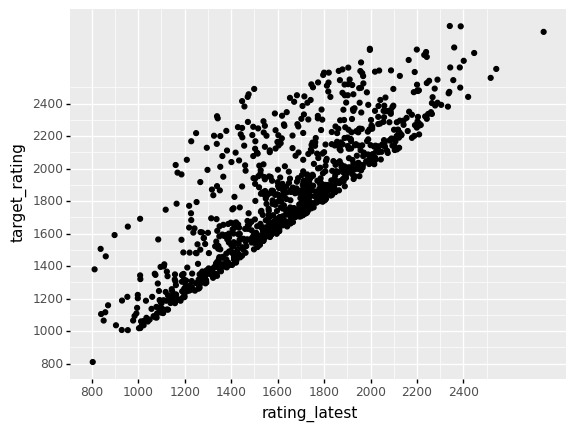

<ggplot: (8793295454730)>

In [272]:
(ggplot(df_targets.sample(1000),aes(x='rating_latest',y='target_rating')) +
 geom_point() +
 scale_x_continuous(breaks=list(range(800,2500,200))) +
  scale_y_continuous(breaks=list(range(800,2500,200)))

        
       )

In [253]:
df_temp = df_targets.copy()
df_temp = df_temp.merge(df_outcomes,on=['user_id','time_control'],how='outer',suffixes=['_latest','_future'])
df_temp.head()

,user_id,time_control,date_latest,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid,target_rating_gain,target_rating,date_future,rating
0,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,-21.0,1600.0,1.0,0.0,0.0,0.0,64.0,1679.0,2019-08-05,1598.0
1,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,-21.0,1600.0,1.0,0.0,0.0,0.0,64.0,1679.0,2019-08-06,1630.0
2,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,-21.0,1600.0,1.0,0.0,0.0,0.0,64.0,1679.0,2019-08-07,1626.0
3,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,-21.0,1600.0,1.0,0.0,0.0,0.0,64.0,1679.0,2019-08-08,1654.0
4,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,-21.0,1600.0,1.0,0.0,0.0,0.0,64.0,1679.0,2019-08-09,1644.0


In [254]:
# Successes - filter to where future rating >= target rating, then take earliest date for each user/time control
df_successes = df_temp.query('rating>=target_rating').sort_values("date_future").drop_duplicates(['user_id','time_control','target_rating'])
print(df_successes.shape)
df_successes.sample(5)

(73250, 21)


,user_id,time_control,date_latest,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid,target_rating_gain,target_rating,date_future,rating
1494703,15187,Bullet,2019-08-04,1380.0,1377.0,1377.0,1388.0,1414.0,3.0,3.0,...,-34.0,1400.0,0.0,1.0,0.0,0.0,65.0,1445.0,2019-08-29,1503.0
2342506,12248,Rapid,2019-08-04,1290.0,1357.0,1301.0,NaN,1486.0,-67.0,-11.0,...,-196.0,1300.0,0.0,0.0,0.0,1.0,203.0,1493.0,2020-07-08,1495.0
22641830,9244,Rapid,2019-07-09,2159.0,2176.0,2138.0,2071.0,2176.0,-17.0,21.0,...,-17.0,2200.0,0.0,0.0,0.0,1.0,13.0,2172.0,2019-12-01,2183.0
5002032,14091,Blitz,2019-08-04,1215.0,1185.0,1232.0,1061.0,1271.0,30.0,-17.0,...,-56.0,1200.0,1.0,0.0,0.0,0.0,18.0,1233.0,2019-08-11,1233.0
2462364,16098,Blitz,2019-08-04,1823.0,1747.0,1787.0,1770.0,1916.0,76.0,36.0,...,-93.0,1800.0,1.0,0.0,0.0,0.0,20.0,1843.0,2019-08-06,1859.0


In [257]:
# Successes and failures 
df_bin = df_targets.merge(df_successes[['user_id','time_control','target_rating','date_future']],on=['user_id','time_control','target_rating'],how='left')
# Was the target rating achieved?
df_bin['y_bin'] = df_bin['date_future'].notna().astype(int)
# If so, when?
df_bin['y_cont'] = (df_bin['date_future']-max_training_date).dt.days
print(df_bin.shape)
df_bin.sample(10)

(108205, 22)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,rating_latest_rounded,blitz,bullet,classical,rapid,target_rating_gain,target_rating,date_future,y_bin,y_cont
37154,3815,Blitz,2019-07-26,1495,1264.0,1156.0,1094.0,1502,231.0,339.0,...,1500,1,0,0,0,6,1501,2019-09-17,1,44.0
77575,4763,Bullet,2019-07-31,1889,1907.0,1907.0,1824.0,1907,-18.0,-18.0,...,1900,0,1,0,0,13,1902,2019-09-25,1,52.0
25361,15526,Blitz,2019-08-04,1934,1711.0,1770.0,1729.0,1934,223.0,164.0,...,1900,1,0,0,0,56,1990,2020-08-14,1,376.0
22344,6177,Blitz,2019-08-04,1128,1141.0,1198.0,NaN,1427,-13.0,-70.0,...,1100,1,0,0,0,428,1556,2020-09-09,1,402.0
65072,8038,Bullet,2019-08-04,1950,1960.0,1982.0,1798.0,2044,-10.0,-32.0,...,2000,0,1,0,0,101,2051,2019-09-10,1,37.0
42564,4051,Classical,2019-07-07,1572,1581.0,1516.0,1372.0,1600,-9.0,56.0,...,1600,0,0,1,0,474,2046,NaT,0,NaN
63926,13705,Rapid,2019-07-09,1639,1710.0,1228.0,NaN,1712,-71.0,411.0,...,1600,0,0,0,1,154,1793,2020-06-05,1,306.0
96605,12821,Rapid,2019-08-02,1502,1487.0,1503.0,1429.0,1567,15.0,-1.0,...,1500,0,0,0,1,136,1638,2020-03-13,1,222.0
21724,11292,Blitz,2019-08-04,1408,1404.0,1300.0,1308.0,1501,4.0,108.0,...,1400,1,0,0,0,206,1614,2020-01-05,1,154.0
32352,12366,Bullet,2019-08-01,2291,2328.0,2193.0,2194.0,2410,-37.0,98.0,...,2300,0,1,0,0,278,2569,2020-03-06,1,215.0


In [263]:
df_cont = df_bin[df_bin['y_bin']==1].copy()

# EDA

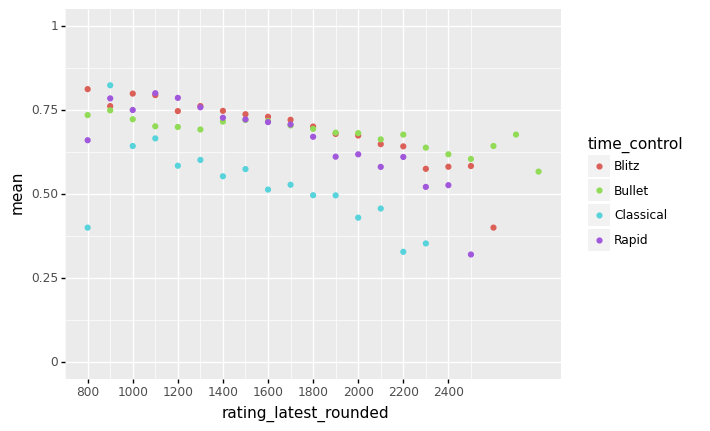

<ggplot: (8793295870540)>

In [264]:
y_bin_by_rating = df_bin.groupby(["rating_latest_rounded","time_control"])['y_bin'].agg([np.mean,len])
(ggplot(y_bin_by_rating[y_bin_by_rating['len']>=25].reset_index(),
        aes(x='rating_latest_rounded',y='mean',color='time_control')) +
 geom_point() +
      scale_x_continuous(breaks=list(range(600,2600,200))) +
         ylim([0,1])
       )

In [265]:
y_cont_by_rating = df_cont.groupby(["rating_latest_rounded",'time_control'])['y_cont'].agg([np.mean,len]).reset_index()
y_cont_by_rating.head()

,rating_latest_rounded,time_control,mean,len
0,600,Blitz,42.500000,10.0
1,600,Bullet,56.400000,5.0
2,600,Rapid,258.800000,5.0
3,700,Blitz,71.928571,14.0
4,700,Bullet,669.000000,1.0


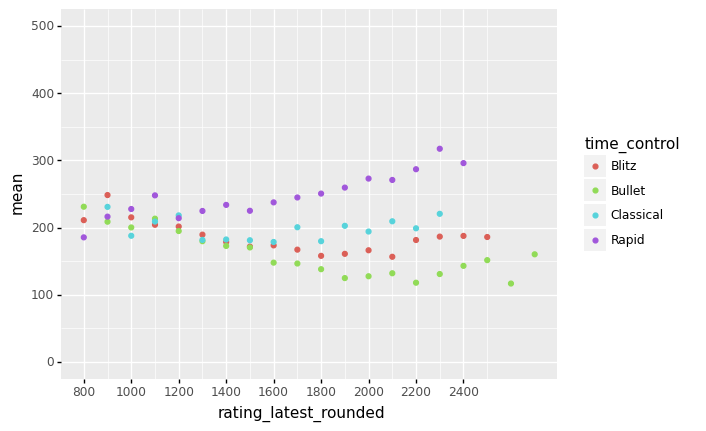

<ggplot: (8793295355558)>

In [266]:
(ggplot(y_cont_by_rating.query('len>=25'),aes(x='rating_latest_rounded',y='mean',color='time_control')) +
        geom_point() +
    ylim(0,500) +
     scale_x_continuous(breaks=list(range(600,2600,200)))
        
       )

# Modeling

In [268]:
predictors = ['target_rating_gain','rating_latest','blitz','bullet','rapid','rating_peak_diff','rating_30_diff']
df_bin_predictors = sm.add_constant(df_bin[predictors])
logit = sm.Logit(endog=df_bin['y_bin'],exog=df_bin_predictors).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.306997
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_bin   No. Observations:               108205
Model:                          Logit   Df Residuals:                   108197
Method:                           MLE   Df Model:                            7
Date:                Tue, 03 Aug 2021   Pseudo R-squ.:                  0.5091
Time:                        21:05:00   Log-Likelihood:                -33219.
converged:                       True   LL-Null:                       -67665.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.7632      0.066     72.316      0.000       4.634       4.892
target_rating_gain    -0.0132    8.7e-05   -151.669      0.000      -0.013      -0.013
rating_latest         -0.0016   3.31e-05    -49.294      0.000      -0.002      -0.002
blitz                  1.6047      0.031     52.047      0.000       1.544       1.665
bullet                 1.3989      0.032     43.581      0.000       1.336       1.462
rapid                  1.4162      0.034     41.782      0.000       1.350       1.483
rating_peak_diff      -0.0035      0.000    -20.982      0.000      -0.004      -0.003
rating_30_diff     -2.382e-05      0.000     -0.155      0.877      -0.000       0.000
======================================================================================
"""

In [270]:
# Regression
df_cont_predictors = sm.add_constant(df_cont[predictors])
ols = sm.OLS(endog=df_cont['y_cont'],exog=df_cont_predictors).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_cont   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     4445.
Date:                Tue, 03 Aug 2021   Prob (F-statistic):               0.00
Time:                        21:06:58   Log-Likelihood:            -4.7995e+05
No. Observations:               73798   AIC:                         9.599e+05
Df Residuals:                   73790   BIC:                         9.600e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                141.5374      3.922     36.088      0.000     133.850     149.225
target_rating_gain     1.0248      0.006    163.846      0.000       1.013       1.037
rating_latest         -0.0083      0.002     -4.336      0.000      -0.012      -0.005
blitz                -28.2703      2.224    -12.710      0.000     -32.630     -23.911
bullet               -45.5741      2.306    -19.760      0.000     -50.095     -41.054
rapid                 30.4343      2.410     12.627      0.000      25.710      35.158
rating_peak_diff       0.3280      0.008     39.743      0.000       0.312       0.344
rating_30_diff        -0.0719      0.009     -7.860      0.000      -0.090      -0.054
==============================================================================
Omnibus:                    13222.165   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22542.747
Skew:                           1.184   Prob(JB):                         0.00
Kurtosis:                       4.312   Cond. No.                     1.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Evaluation

## Classification Evaluation

In [273]:
df_bin['prob'] = logit.predict(exog=df_bin_predictors)
df_bin['prob'].describe()

count    108205.000000
mean          0.682020
std           0.351330
min           0.000024
25%           0.461032
50%           0.867924
75%           0.954193
max           0.999847
Name: prob, dtype: float64

In [286]:
print(round(df_bin['prob'].mean(),3))
print(round(df_bin['y_bin'].mean(),3))

0.682
0.682


In [291]:
round(((df_bin['prob']-df_bin['y_bin'])**2).mean(),3)

0.091

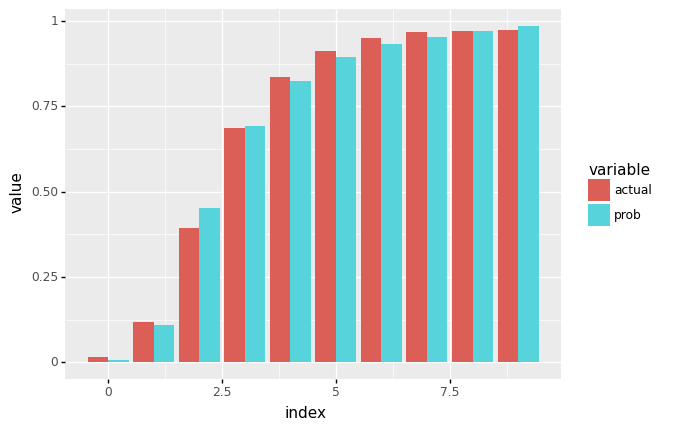

<ggplot: (8793295804350)>

In [318]:
df_bin['decile'] = pd.qcut(df_bin['prob'],q=10)
deciles = df_bin.groupby('decile')[['prob','y_bin']].mean().reset_index()
deciles['index'] = np.arange(len(deciles))
decile_probs = deciles[['prob','index']].rename(columns={"prob":"value"})
decile_probs['variable'] = 'prob'
decile_actuals = deciles[['y_bin','index']].rename(columns={"y_bin":"value"})
decile_actuals['variable'] = 'actual'
deciles = pd.concat([decile_probs,decile_actuals],axis=0)
(ggplot(deciles,aes(x='index',y='value',fill='variable')) +
 geom_bar(stat='identity',position='dodge')

)

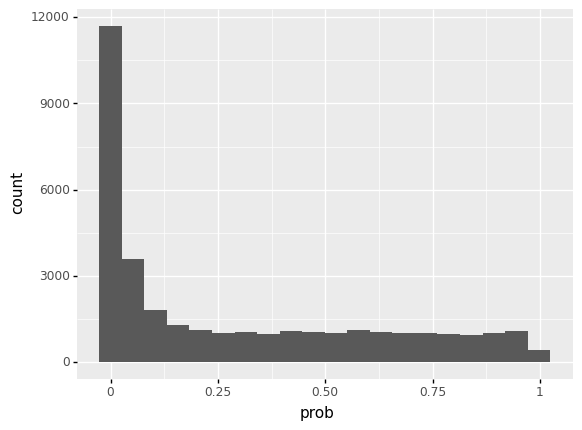

<ggplot: (8790308929106)>

In [326]:
(ggplot(df_bin.query('y_bin==0'),aes(x='prob')) +
geom_histogram(bins=20))

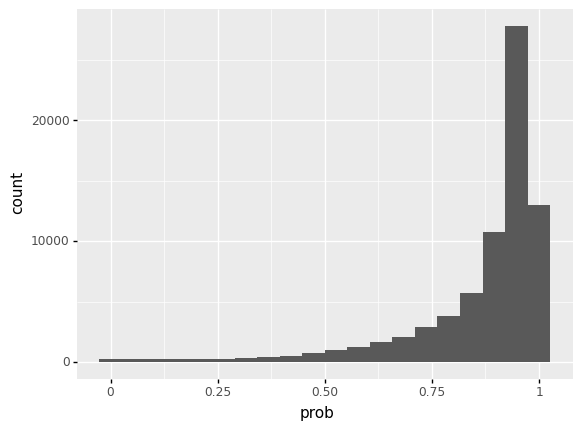

<ggplot: (8790308929055)>

In [327]:
(ggplot(df_bin.query('y_bin==1'),aes(x='prob')) +
geom_histogram(bins=20))

## Regression Evaluation

In [274]:
df_cont['pred'] = ols.predict(exog=df_cont_predictors)
#df_cont.loc[df_cont['pred']<0,'pred'] = 0
df_cont['pred'].describe()

count    73798.000000
mean       185.202756
std        104.888890
min       -235.049372
25%        115.138741
50%        161.137504
75%        230.814295
max       1150.483800
Name: pred, dtype: float64

In [275]:
len(df_cont[df_cont['pred']<0])/len(df_cont)

0.003631534729938481

In [329]:
df_cont['error'] = df_cont['pred']-df_cont['y_cont']
df_cont['abs_error'] = df_cont['error'].abs()

In [330]:
df_cont['error'].describe().round()

count    73798.0
mean        -0.0
std        162.0
min       -717.0
25%        -64.0
50%         50.0
75%        103.0
max        784.0
Name: error, dtype: float64

In [331]:
df_cont['abs_error'].describe().round()

count    73798.0
mean       123.0
std        105.0
min          0.0
25%         53.0
50%         95.0
75%        154.0
max        784.0
Name: abs_error, dtype: float64

In [362]:
df_cont['target_rating_gain_rounded'] = df_cont['target_rating_gain'].round(-2)
error_summary = df_cont.groupby(['target_rating_gain_rounded','rating_latest_rounded','time_control'])[['pred','y_cont','abs_error','error']].agg([np.mean]).round().astype(int)
sizes = df_cont.groupby(['target_rating_gain_rounded','rating_latest_rounded','time_control']).size().reset_index()
sizes.rename(columns={0:"n"},inplace=True)
error_summary.columns = ['mean_pred','mean_actual','mean_abs_error','mean_error']
error_summary = error_summary.reset_index().merge(sizes,on=['target_rating_gain_rounded','rating_latest_rounded','time_control'])
error_summary = error_summary.query('n>30')
error_summary.sort_values("mean_abs_error",ascending=False).head()

,target_rating_gain_rounded,rating_latest_rounded,time_control,mean_pred,mean_actual,mean_abs_error,mean_error,n
295,300,2200,Blitz,353,538,246,-185,31
291,300,2100,Blitz,351,492,231,-141,46
149,100,2300,Rapid,230,377,228,-147,38
287,300,2000,Blitz,352,501,222,-149,84
225,200,2300,Blitz,272,454,219,-182,52


## Features
- Target time control (likely interacted with various other features)
- Target rating gain
- Current rating (likely nonlinear relationship)
- Rating growth in last 30 days / 90 days / 180 days
- Rating volatility measures
- Peak historical rating relative to current rating
- Rating in other time controls + puzzles
- Rating growth in other time controls + puzzles
- Difference between other time control ratings + target time control rating
- How long you've been on lichess
- How many games you've played (ever, and within last 30 days, and within the target time control - if you haven't played many it could mean more uncertainty). Consider that most discord bot users will have played more recent rated games in the target time control than the typical user in the training data. 
- Last time you played a rated game in the target time control (if it's a long time ago, it could mean more uncertainty)

## Outcomes
- Will you ever achieve a rating that's X rating points higher than your current rating in the next Y months (X is calculated from target rating submitted by user, Y = 24?)
- If so, when will you first reach the target rating? (point estimate + prediction interval of dates) - use number of days as outcome, then transform to date for the bot message
- Try to tweak model to avoid negative predictions, and manually override when needed. Same with predictions greater than 2 years out.


## Notes:
- Use cross-validation since sample size might be constrained
- Need to impute nulls
- Need to write code for scoring based on discord input (including lichess API querying)
- Need to figure out how to make prediction interval
- Add more comments + documentation to final version
